In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)

# Import Data

In [2]:
#read the two files
item_name=pd.read_csv("./dataset/grocery/item_to_id.csv")

In [3]:
item_name.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [5]:
item_name.shape

(48, 2)

In [6]:
purchase=pd.read_csv("./dataset/grocery/purchase_history.csv")

In [7]:
purchase.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


# Data Exploration

Q: Customer who bought the highest number of items overall

Let’s count how many items each user bought in total.


In [8]:
#let's split on comma and get the length
purchase['item_count'] = purchase['id'].apply(lambda x: len(x.split(',')))

In [9]:
purchase.head()

,user_id,id,item_count
0,222087,"27,26",2
1,1343649,"6,47,17",3
2,404134,"18,12,23,22,27,43,38,20,35,1",10
3,1110200,"9,23,2,20,26,47,37",7
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4...",20


In [12]:
purchase.sort_values(by = 'item_count', ascending = False).head()

,user_id,id,item_count
3332,388149,"18,38,36,7,1,10,45,26,39,5,44,40,32,25,9,21,28...",27
16424,1498027,"2,23,14,47,15,7,24,33,3,16,48,34,13,18,25,9,38...",27
21269,518659,"3,9,40,32,11,10,19,46,44,45,13,2,21,28,25,38,2...",25
25339,672816,"10,44,41,8,9,32,48,30,11,24,12,42,13,20,25,38,...",25
2085,591753,"48,14,21,16,8,12,9,33,26,22,40,20,32,38,2,4,3,...",25


In [15]:
 #so now we can simply group by user, sum item_count and pick the max
max_bought = purchase.groupby('user_id')['item_count'].sum().reset_index()

In [16]:
max_bought = max_bought.loc[max_bought ['item_count'].idxmax()]

In [17]:
max_bought

user_id       269335
item_count        72
Name: 4445, dtype: int64

In [18]:
print("The user with the highest count is", max_bought[0], 
      "having bought", max_bought[1], "items")

The user with the highest count is 269335 having bought 72 items


Q: For each item, the customer who bought that product the most
This is similar to the previous question. We need to group by item and user and find max.

In [19]:
#create a vector of all items purchased in the same order as the original dataset
item_id = purchase['id'].str.split(",")

In [20]:
item_id

0                                                 [27, 26]
1                                              [6, 47, 17]
2                  [18, 12, 23, 22, 27, 43, 38, 20, 35, 1]
3                               [9, 23, 2, 20, 26, 47, 37]
4        [31, 18, 5, 13, 1, 21, 48, 16, 26, 2, 44, 32, ...
                               ...                        
39469                                  [48, 42, 44, 10, 2]
39470    [23, 21, 26, 27, 41, 9, 47, 43, 20, 40, 16, 24...
39471    [3, 39, 28, 4, 1, 43, 47, 27, 18, 25, 44, 10, ...
39472                   [13, 39, 20, 32, 37, 1, 3, 18, 34]
39473          [39, 40, 20, 3, 10, 42, 38, 43, 28, 25, 13]
Name: id, Length: 39474, dtype: object

In [21]:
item_id = np.hstack(item_id)

In [22]:
item_id

array(['27', '26', '6', ..., '28', '25', '13'], dtype='<U2')

In [23]:
#create a vector with all user_ids. Each user id is repeated the number of times based on to their corresponding item count. So the first user will be repeated twice, etc.
user_id = np.repeat(purchase['user_id'], purchase['item_count'])

In [24]:
user_id

0         222087
0         222087
1        1343649
1        1343649
1        1343649
          ...   
39473     517744
39473     517744
39473     517744
39473     517744
39473     517744
Name: user_id, Length: 319995, dtype: int64

In [25]:
#make them into a dataframe
data_long = pd.DataFrame(user_id)

In [26]:
data_long.head()

,user_id
0,222087
0,222087
1,1343649
1,1343649
1,1343649


In [27]:
data_long['item_id'] = item_id

In [28]:
data_long.head()

,user_id,item_id
0,222087,27
0,222087,26
1,1343649,6
1,1343649,47
1,1343649,17


In [29]:
#now we can group by user and item, count, and then find the max row for each item
data_long = data_long.groupby(['item_id', 'user_id']).size().reset_index(name = 'count')

In [30]:
data_long.head()

,item_id,user_id,count
0,1,223,1
1,1,323,1
2,1,394,1
3,1,453,1
4,1,553,1


In [38]:
data_long = data_long[data_long.groupby('item_id')['count'].transform(max) == data_long['count']]

In [39]:
data_long.head()

,item_id,user_id,count
171,1,31625,4
369,1,68836,4
2913,1,540483,4
5920,1,1091637,4
7021,1,1301034,4


In [40]:
data_long.dtypes

item_id    object
user_id     int64
count       int64
dtype: object

In [41]:
#add item names
data_long['item_id'] = data_long['item_id'].astype(int)
data_long = pd.merge(data_long, item_name, how='left', left_on='item_id', right_on='Item_id')

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
#check the dataset for the first item
print("The following user(s) have bought", 
       item_name.query('Item_id==1')['Item_name'].values,
      "the most:",
       data_long.query('item_id==1')['user_id'].values
     )

The following user(s) have bought ['sugar'] the most: [  31625   68836  540483 1091637 1301034]


In [43]:
data_long.head()

,item_id,user_id,count,Item_name,Item_id
0,1,31625,4,sugar,1
1,1,68836,4,sugar,1
2,1,540483,4,sugar,1
3,1,1091637,4,sugar,1
4,1,1301034,4,sugar,1


# Model Building

Q: Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster

Since each item can only belong to one cluster, this is a clustering problem. If an item could have belonged to multiple groups, this would have become an association rule task.

There are several ways to build the clusters. An options is:

Build a N X M matrix where N (rows) represents the transactions and M (columns) is the items

For each row, put 1 if a given item was bought and 0 otherwise. I.e. the first row, will have all zeros except for the columns “item 26” and “item 27” Create an M X M similarity matrix from the matrix above. Most common similarity metrics are correlation or cosine similarity. Most clustering functions will do this internally when fed the N X M matrix, so it doesn’t need to be done manually. Apply clustering to the similarity matrix. Each cluster will contain items that are likely to be bought together. As clustering technique, most common choices are k-means and hierarchical clustering. K-means is simpler and easier to explain it. So, often, you want to try k-means first, especially if the dataset is simple and you expect k-means to do well. If that doesn’t work, move to hierarchical clustering.

Here we will show both approaches. K-means with Python

In [44]:
#firstly, let's create the dataset where each row is a transaction and columns are all items with 1/0 values if bought or not
  
#let's start from the long dataset: Item_id comes from the previous section, i.e. all items bought as a vector. Also need to add a column regarding which transaction it was. we need it for later when we make the dataset wide. 
 
#make them into a dataframe
data_clustering = pd.DataFrame({'item_id' : item_id})

In [45]:
data_clustering.head()

,item_id
0,27
1,26
2,6
3,47
4,17


In [47]:
data_clustering['transaction_id']= np.repeat(range(len(purchase['user_id'])), purchase['item_count'])

In [48]:
data_clustering.head()

,item_id,transaction_id
0,27,0
1,26,0
2,6,1
3,47,1
4,17,1


In [51]:
data_clustering.transaction_id.unique()

array([    0,     1,     2, ..., 39471, 39472, 39473])

In [49]:
data_clustering.dtypes

item_id           object
transaction_id     int64
dtype: object

In [50]:
#let's get the item names instead of the ids
data_clustering['item_id'] = data_clustering['item_id'].astype(int)
data_clustering = pd.merge(data_clustering, item_name, how='left', left_on='item_id', right_on='Item_id')[['transaction_id', 'Item_name']]
data_clustering.head()

,transaction_id,Item_name
0,0,dishwashing
1,0,spaghetti sauce
2,1,poultry
3,1,pork
4,1,beef


In [52]:
#now we make it wide, i.e. each column is an item, each row a transaction, values are 0/1 if a given item was bought in that transaction
data_clustering['binary_value'] = 1

In [53]:
data_clustering.head()

,transaction_id,Item_name,binary_value
0,0,dishwashing,1
1,0,spaghetti sauce,1
2,1,poultry,1
3,1,pork,1
4,1,beef,1


In [54]:
data_clustering = data_clustering.pivot(index='transaction_id', columns='Item_name').fillna(0)

In [55]:
data_clustering.head()

binary_value                                   ...                                           
Item_name      aluminum foil apples baby items bagels bananas  ...  tea toilet paper tortillas waffles yogurt
transaction_id                                                 ...                                           
0                        0.0    0.0        0.0    0.0     0.0  ...  0.0          0.0       0.0     0.0    0.0
1                        0.0    0.0        0.0    0.0     0.0  ...  0.0          0.0       0.0     0.0    0.0
2                        0.0    0.0        0.0    0.0     0.0  ...  1.0          0.0       0.0     0.0    0.0
3                        0.0    0.0        0.0    0.0     0.0  ...  1.0          0.0       0.0     0.0    0.0
4                        0.0    1.0        0.0    1.0     0.0  ...  0.0          0.0       0.0     1.0    1.0

[5 rows x 48 columns]

In [56]:
#let's check everything worked:  
print( 
# of rows same as # transactions, 
data_clustering.shape[0] == purchase.shape[0] and
# of columns same as # items
data_clustering.shape[1] == len(np.unique(item_id)) and
#since each row has 1 if an item was bought and 0 otherwise, sum of all its elements should be the same as sum purchase.item_count  
data_clustering.values.sum() == purchase['item_count'].sum()
)

True


In [59]:
data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39474 entries, 0 to 39473
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   (binary_value, aluminum foil)      39474 non-null  float64
 1   (binary_value, apples)             39474 non-null  float64
 2   (binary_value, baby items)         39474 non-null  float64
 3   (binary_value, bagels)             39474 non-null  float64
 4   (binary_value, bananas)            39474 non-null  float64
 5   (binary_value, beef)               39474 non-null  float64
 6   (binary_value, berries)            39474 non-null  float64
 7   (binary_value, broccoli)           39474 non-null  float64
 8   (binary_value, butter)             39474 non-null  float64
 9   (binary_value, canned vegetables)  39474 non-null  float64
 10  (binary_value, carrots)            39474 non-null  float64
 11  (binary_value, cauliflower)        39474 non-null  flo

In [66]:
from sklearn.metrics.pairwise import pairwise_distances

In [67]:
#create correlation matrix, other distances would work similarly. We will later cluster on this
data_clustering_corr = pairwise_distances(data_clustering.T, metric="correlation")

With k-means, we need to choose the number of clusters before building the model. A common way to approach this is: Define from a product standpoint a range of cluster numbers that makes sense. I.e. the output of this challenge are aisles in a grocery store. It would make no sense to have too many or too few because it would confuse customers either way. In real life, this step is probably the most important one and a lot of data science work and design discussions go into this to figure out a range of acceptable cluster numbers. Here we don’t have much information, so we just pick numbers that kinda make sense. We have 48 items and say, on an average, we would like to have between 7 and 4 items per aisle. Therefore, we will try between 6 and 12 clusters.

Build k-means for all the possible cluster numbers, look at k-means loss, and choose the optimal cluster number accordingly

In [68]:
from sklearn.cluster import KMeans
  
#now let's build different models using kmeans and check inertia of each.
cluster_inertia = [] # tells us how spread out are elements within the same cluster. The smaller the better.
for i in range(6,13): # We chose this range based on product-related considerations
    kmeans = KMeans(n_clusters=i, random_state=99)
    kmeans.fit(data_clustering_corr)
    cluster_inertia.append(kmeans.inertia_)

Text(0, 0.5, 'Inertia')

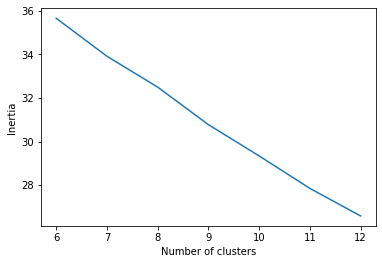

In [72]:
#let's plot them
plt.plot(range(6,13), cluster_inertia)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

There doesn’t appear to be any major inflection point in the plot. So we will choose 12.

In [71]:
#Build k-means with 12 clusters
kmeans = KMeans(n_clusters=12, random_state=99)
#fit the data
clusters = kmeans.fit_predict(data_clustering_corr)
  
#check the final clusters
final_clusters = pd.DataFrame({'cluster':clusters, 'product_names':data_clustering.columns.get_level_values(1)})
final_clusters.sort_values('cluster')

,cluster,product_names
18,0,dishwashing
27,0,laundry detergent
1,1,apples
4,1,bananas
22,1,grapefruit
6,1,berries
14,1,cherries
29,2,milk
19,2,eggs
13,2,cheeses


In [73]:
data_clustering.columns.get_level_values(1)

Index(['aluminum foil', 'apples', 'baby items', 'bagels', 'bananas', 'beef', 'berries', 'broccoli', 'butter', 'canned vegetables', 'carrots', 'cauliflower', 'cereals', 'cheeses', 'cherries', 'coffee', 'cucumbers', 'dinner rolls', 'dishwashing ', 'eggs', 'flour', 'frozen vegetables', 'grapefruit', 'hand soap', 'ice cream', 'juice', 'ketchup',
       'laundry detergent', 'lettuce', 'milk', 'paper towels', 'pasta', 'pet items', 'pork', 'poultry', 'sandwich bags', 'sandwich loaves', 'shampoo', 'shaving cream', 'soap', 'soda', 'spaghetti sauce', 'sugar', 'tea', 'toilet paper', 'tortillas', 'waffles', 'yogurt'],
      dtype='object', name='Item_name')

# Conclusion

Overall, the clusters make sense. So we are good. Possible and fairly common next steps after building k-means are:

If we end up with some clusters with too few events, that might not make sense from a product standpoint. If so, we can put them together and label this cluster “other”

Look at the distance of each element from its cluster centroid. If this value is > than a certain threshold, assign that element to the “other” cluster